# EE 371Q: Final Project
## Rijul Nanda, Youchan Lee


##### In this project, we will analyze different images of the eye to detect eye diseases. The original dataset was taken from here: 
##### https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k
##### Additional data for glaucoma: https://www.kaggle.com/sshikamaru/glaucoma-detection/version/2
##### Additional data for diabetic retinopathy: https://www.kaggle.com/c/diabetic-retinopathy-detection/data
##### Additional data for hypertension: https://retinagallery.com/thumbnails.php?album=731


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
import pandas as pd
import skimage.io
import scipy.io
import math
import cv2
from PIL import Image, ImageOps

import os
from os import path
import shutil

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from random import sample
import seaborn as sns
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model
from scikitplot.metrics import plot_confusion_matrix as plt_con_mat

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from tensorflow.keras.preprocessing.image import load_img,img_to_array

import random

from keras.utils.np_utils import to_categorical

import tensorflow as tf
import tensorflow_addons as tfa
import pathlib
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau

In [13]:
# Read the excel sheet
xl = pd.read_excel('ocular_disease_fundus/ODIR-5K/ODIR-5K/data.xlsx')
xl

ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
0        0           69      Female     0_left.jpg     0_right.jpg   
1        1           57        Male     1_left.jpg     1_right.jpg   
2        2           42        Male     2_left.jpg     2_right.jpg   
3        3           66        Male     3_left.jpg     3_right.jpg   
4        4           53        Male     4_left.jpg     4_right.jpg   
...    ...          ...         ...            ...             ...   
3495  4686           63        Male  4686_left.jpg  4686_right.jpg   
3496  4688           42        Male  4688_left.jpg  4688_right.jpg   
3497  4689           54        Male  4689_left.jpg  4689_right.jpg   
3498  4690           57        Male  4690_left.jpg  4690_right.jpg   
3499  4784           58        Male  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
0                                              cataract   
1                                         normal fundus   
2     laser spot，moderate non proliferative retinopathy   
3                                         normal fundus   
4                           macular epiretinal membrane   
...                                                 ...   
3495                severe nonproliferative retinopathy   
3496             moderate non proliferative retinopathy   
3497                  mild nonproliferative retinopathy   
3498                  mild nonproliferative retinopathy   
3499  hypertensive retinopathy，age-related macular d...   

                              Right-Diagnostic Keywords  N  D  G  C  A  H  M  \
0                                         normal fundus  0  0  0  1  0  0  0   
1                                         normal fundus  1  0  0  0  0  0  0   
2                moderate non proliferative retinopathy  0  1  0  0  0  0  0   
3                       branch retinal artery occlusion  0  0  0  0  0  0  0   
4                     mild nonproliferative retinopathy  0  1  0  0  0  0  0   
...                                                 ... .. .. .. .. .. .. ..   
3495                 proliferative diabetic retinopathy  0  1  0  0  0  0  0   
3496             moderate non proliferative retinopathy  0  1  0  0  0  0  0   
3497                                      normal fundus  0  1  0  0  0  0  0   
3498                  mild nonproliferative retinopathy  0  1  0  0  0  0  0   
3499  hypertensive retinopathy，age-related macular d...  0  0  0  0  1  1  0   

      O  
0     0  
1     0  
2     1  
3     1  
4     1  
...  ..  
3495  0  
3496  0  
3497  0  
3498  0  
3499  0  

[3500 rows x 15 columns]

In [52]:
diseases = list(xl.columns[7:15])
xl['Labels'] = xl.apply(lambda x:[disease for disease in diseases if x[disease]==1], axis=1)
xl

ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
0        0           69      Female     0_left.jpg     0_right.jpg   
1        1           57        Male     1_left.jpg     1_right.jpg   
2        2           42        Male     2_left.jpg     2_right.jpg   
3        3           66        Male     3_left.jpg     3_right.jpg   
4        4           53        Male     4_left.jpg     4_right.jpg   
...    ...          ...         ...            ...             ...   
3495  4686           63        Male  4686_left.jpg  4686_right.jpg   
3496  4688           42        Male  4688_left.jpg  4688_right.jpg   
3497  4689           54        Male  4689_left.jpg  4689_right.jpg   
3498  4690           57        Male  4690_left.jpg  4690_right.jpg   
3499  4784           58        Male  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
0                                              cataract   
1                                         normal fundus   
2     laser spot，moderate non proliferative retinopathy   
3                                         normal fundus   
4                           macular epiretinal membrane   
...                                                 ...   
3495                severe nonproliferative retinopathy   
3496             moderate non proliferative retinopathy   
3497                  mild nonproliferative retinopathy   
3498                  mild nonproliferative retinopathy   
3499  hypertensive retinopathy，age-related macular d...   

                              Right-Diagnostic Keywords  N  D  G  C  A  H  M  \
0                                         normal fundus  0  0  0  1  0  0  0   
1                                         normal fundus  1  0  0  0  0  0  0   
2                moderate non proliferative retinopathy  0  1  0  0  0  0  0   
3                       branch retinal artery occlusion  0  0  0  0  0  0  0   
4                     mild nonproliferative retinopathy  0  1  0  0  0  0  0   
...                                                 ... .. .. .. .. .. .. ..   
3495                 proliferative diabetic retinopathy  0  1  0  0  0  0  0   
3496             moderate non proliferative retinopathy  0  1  0  0  0  0  0   
3497                                      normal fundus  0  1  0  0  0  0  0   
3498                  mild nonproliferative retinopathy  0  1  0  0  0  0  0   
3499  hypertensive retinopathy，age-related macular d...  0  0  0  0  1  1  0   

      O  Labels  
0     0     [C]  
1     0     [N]  
2     1  [D, O]  
3     1     [O]  
4     1  [D, O]  
...  ..     ...  
3495  0     [D]  
3496  0     [D]  
3497  0     [D]  
3498  0     [D]  
3499  0  [A, H]  

[3500 rows x 16 columns]

Now, let's look at an example image just to see what they all look like, and to ensure we can open images in python.

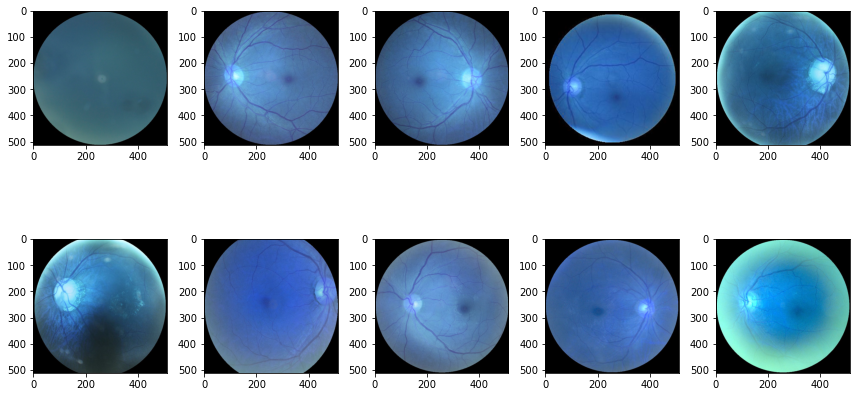

In [53]:
plt.figure(figsize=(12,7))
example_image = 'ocular_disease_fundus/preprocessed_images/' + '0_left.jpg'
im = cv2.imread(example_image)
plt.subplot(251)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '1_left.jpg'
im = cv2.imread(example_image)
plt.subplot(252)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '1_right.jpg'
im = cv2.imread(example_image)
plt.subplot(253)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '3_left.jpg'
im = cv2.imread(example_image)
plt.subplot(254)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '4_right.jpg'
im = cv2.imread(example_image)
plt.subplot(255)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '4_left.jpg'
im = cv2.imread(example_image)
plt.subplot(256)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '10_right.jpg'
im = cv2.imread(example_image)
plt.subplot(257)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '21_left.jpg'
im = cv2.imread(example_image)
plt.subplot(258)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '40_right.jpg'
im = cv2.imread(example_image)
plt.subplot(259)
plt.imshow(im)

example_image = 'ocular_disease_fundus/preprocessed_images/' + '31_left.jpg'
im = cv2.imread(example_image)
plt.subplot(2,5,10)
plt.imshow(im)

plt.tight_layout()

In [54]:
# Split up the left and right eye information

cols = ['Image', 'Keywords', 'Age', 'Sex', 'Labels']

left = xl[['Left-Fundus', 'Left-Diagnostic Keywords', 'Patient Age', 'Patient Sex', 'Labels']]
left.columns = cols

right = xl[['Right-Fundus', 'Right-Diagnostic Keywords', 'Patient Age', 'Patient Sex', 'Labels']]
right.columns = cols

# combine them back
both_eyes = pd.concat([left, right], axis=0)

both_eyes

Image                                           Keywords  Age  \
0         0_left.jpg                                           cataract   69   
1         1_left.jpg                                      normal fundus   57   
2         2_left.jpg  laser spot，moderate non proliferative retinopathy   42   
3         3_left.jpg                                      normal fundus   66   
4         4_left.jpg                        macular epiretinal membrane   53   
...              ...                                                ...  ...   
3495  4686_right.jpg                 proliferative diabetic retinopathy   63   
3496  4688_right.jpg             moderate non proliferative retinopathy   42   
3497  4689_right.jpg                                      normal fundus   54   
3498  4690_right.jpg                  mild nonproliferative retinopathy   57   
3499  4784_right.jpg  hypertensive retinopathy，age-related macular d...   58   

         Sex  Labels  
0     Female     [C]  
1       Male     [N]  
2       Male  [D, O]  
3       Male     [O]  
4       Male  [D, O]  
...      ...     ...  
3495    Male     [D]  
3496    Male     [D]  
3497    Male     [D]  
3498    Male     [D]  
3499    Male  [A, H]  

[7000 rows x 5 columns]

### Start with the basic 7 diseases.

In [55]:
def cataract(diagnostic_keyword):
    if "cataract" in diagnostic_keyword:
        return 1
    else:
        return 0
    
def normal(diagnostic_keyword):
    if "normal" in diagnostic_keyword:
        return 1
    else:
        return 0
    
def diabetes(diagnostic_keyword):
    if "proliferative retinopathy" in diagnostic_keyword or 'diabetic' in diagnostic_keyword:
        return 1
    else:
        return 0
    
def glaucoma(diagnostic_keyword):
    if "glaucoma" in diagnostic_keyword:
        return 1
    else:
        return 0
    
def amd(diagnostic_keyword):
    if "age-related" in diagnostic_keyword:
        return 1
    else:
        return 0

def hypertension(diagnostic_keyword):
    if "hypertens" in diagnostic_keyword:
        return 1
    else:
        return 0

def myopia(diagnostic_keyword):
    if "myopia" in diagnostic_keyword:
        return 1
    else:
        return 0

In [56]:
xl["left_cataract"] = xl["Left-Diagnostic Keywords"].apply(lambda word: cataract(word))
xl["right_cataract"] = xl["Right-Diagnostic Keywords"].apply(lambda word: cataract(word))

xl["left_normal"] = xl["Left-Diagnostic Keywords"].apply(lambda word: normal(word))
xl["right_normal"] = xl["Right-Diagnostic Keywords"].apply(lambda word: normal(word))

xl["left_diabetes"] = xl["Left-Diagnostic Keywords"].apply(lambda word: diabetes(word))
xl["right_diabetes"] = xl["Right-Diagnostic Keywords"].apply(lambda word: diabetes(word))

xl["left_glaucoma"] = xl["Left-Diagnostic Keywords"].apply(lambda word: glaucoma(word))
xl["right_glaucoma"] = xl["Right-Diagnostic Keywords"].apply(lambda word: glaucoma(word))

xl["left_amd"] = xl["Left-Diagnostic Keywords"].apply(lambda word: amd(word))
xl["right_amd"] = xl["Right-Diagnostic Keywords"].apply(lambda word: amd(word))

xl["left_hypertension"] = xl["Left-Diagnostic Keywords"].apply(lambda word: hypertension(word))
xl["right_hypertension"] = xl["Right-Diagnostic Keywords"].apply(lambda word: hypertension(word))

xl["left_myopia"] = xl["Left-Diagnostic Keywords"].apply(lambda word: myopia(word))
xl["right_myopia"] = xl["Right-Diagnostic Keywords"].apply(lambda word: myopia(word))

xl

ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
0        0           69      Female     0_left.jpg     0_right.jpg   
1        1           57        Male     1_left.jpg     1_right.jpg   
2        2           42        Male     2_left.jpg     2_right.jpg   
3        3           66        Male     3_left.jpg     3_right.jpg   
4        4           53        Male     4_left.jpg     4_right.jpg   
...    ...          ...         ...            ...             ...   
3495  4686           63        Male  4686_left.jpg  4686_right.jpg   
3496  4688           42        Male  4688_left.jpg  4688_right.jpg   
3497  4689           54        Male  4689_left.jpg  4689_right.jpg   
3498  4690           57        Male  4690_left.jpg  4690_right.jpg   
3499  4784           58        Male  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
0                                              cataract   
1                                         normal fundus   
2     laser spot，moderate non proliferative retinopathy   
3                                         normal fundus   
4                           macular epiretinal membrane   
...                                                 ...   
3495                severe nonproliferative retinopathy   
3496             moderate non proliferative retinopathy   
3497                  mild nonproliferative retinopathy   
3498                  mild nonproliferative retinopathy   
3499  hypertensive retinopathy，age-related macular d...   

                              Right-Diagnostic Keywords  N  D  G  ...  \
0                                         normal fundus  0  0  0  ...   
1                                         normal fundus  1  0  0  ...   
2                moderate non proliferative retinopathy  0  1  0  ...   
3                       branch retinal artery occlusion  0  0  0  ...   
4                     mild nonproliferative retinopathy  0  1  0  ...   
...                                                 ... .. .. ..  ...   
3495                 proliferative diabetic retinopathy  0  1  0  ...   
3496             moderate non proliferative retinopathy  0  1  0  ...   
3497                                      normal fundus  0  1  0  ...   
3498                  mild nonproliferative retinopathy  0  1  0  ...   
3499  hypertensive retinopathy，age-related macular d...  0  0  0  ...   

      left_diabetes  right_diabetes  left_glaucoma  right_glaucoma  left_amd  \
0                 0               0              0               0         0   
1                 0               0              0               0         0   
2                 1               1              0               0         0   
3                 0               0              0               0         0   
4                 0               1              0               0         0   
...             ...             ...            ...             ...       ...   
3495              1               1              0               0         0   
3496              1               1              0               0         0   
3497              1               0              0               0         0   
3498              1               1              0               0         0   
3499              0               0              0               0         1   

     right_amd  left_hypertension  right_hypertension  left_myopia  \
0            0                  0                   0            0   
1            0                  0                   0            0   
2            0                  0                   0            0   
3            0                  0                   0            0   
4            0                  0                   0            0   
...        ...                ...                 ...          ...   
3495         0                  0                   0            0   
3496         0                  0                   0       

In [57]:
# get all images that have cataracts
left_cataract = xl.loc[(xl.left_cataract == 1) & (xl.C == 1)]['Left-Fundus'].values
right_cataract = xl.loc[(xl.right_cataract == 1) & (xl.C == 1)]['Right-Fundus'].values

# get all images that have normal
left_normal = xl.loc[(xl.left_normal == 1) & (xl.N == 1)]['Left-Fundus'].values
right_normal = xl.loc[(xl.right_normal == 1) & (xl.N == 1)]['Right-Fundus'].values

# get all images that have diabetes
left_diabetes = xl.loc[(xl.left_diabetes == 1) & (xl.D == 1)]['Left-Fundus'].values
right_diabetes = xl.loc[(xl.right_diabetes == 1) & (xl.D == 1)]['Right-Fundus'].values

# get all images that have glaucoma
left_glaucoma = xl.loc[(xl.left_glaucoma == 1) & (xl.G == 1)]['Left-Fundus'].values
right_glaucoma = xl.loc[(xl.right_glaucoma == 1) & (xl.G == 1)]['Right-Fundus'].values

# get all images that have AMD
left_amd = xl.loc[(xl.left_amd == 1) & (xl.A == 1)]['Left-Fundus'].values
right_amd = xl.loc[(xl.right_amd == 1) & (xl.A == 1)]['Right-Fundus'].values

# get all images that have hypertension
left_hyper = xl.loc[(xl.left_hypertension == 1) & (xl.H == 1)]['Left-Fundus'].values
right_hyper = xl.loc[(xl.right_hypertension == 1) & (xl.H == 1)]['Right-Fundus'].values

# get all images that have myopia
left_myopia = xl.loc[(xl.left_myopia == 1) & (xl.M == 1)]['Left-Fundus'].values
right_myopia = xl.loc[(xl.right_myopia == 1) & (xl.M == 1)]['Right-Fundus'].values

In [58]:
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)
diabetes = np.concatenate((left_diabetes, right_diabetes), axis=0)
glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis=0)
amd = np.concatenate((left_amd, right_amd), axis=0)
hyper = np.concatenate((left_hyper, right_hyper), axis=0)
myopia = np.concatenate((left_myopia, right_myopia), axis=0)

In [59]:
# how many images total that are other?
print(7000 - (len(diabetes) + len(cataract) + len(normal) + len(glaucoma) + len(amd) + len(hyper) + len(myopia)))

1551


In [14]:
# Create folders with all of the images classified into them - training images
src = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images"
dst_D = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/diabetes"
dst_N = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/normal"
dst_G = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/glaucoma"
dst_A = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/amd"
dst_H = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/hypertension"
dst_M = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/myopia"
dst_C = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/cataracts"

for f in cataract:
    shutil.copy(path.join(src, f), dst_C)

for f in diabetes:
    shutil.copy(path.join(src, f), dst_D)

for f in normal:
    shutil.copy(path.join(src, f), dst_N)

for f in glaucoma:
    shutil.copy(path.join(src, f), dst_G)

for f in amd:
    shutil.copy(path.join(src, f), dst_A)
    
for f in hyper:
    shutil.copy(path.join(src, f), dst_H)

for f in myopia:
    shutil.copy(path.join(src, f), dst_M)

### We run individual diseases vs. normal fundus images using ResNet50, AlexNet, and VGG19

In [42]:
path = "ocular_disease_fundus/"
df = pd.read_csv(path + "full_df.csv")
df.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

##### Inspiration for several of our individual models are from the following sites: https://keras.io/api/applications/vgg/
##### - https://engmrk.com/alexnet-implementation-using-keras/
##### - https://www.kaggle.com/taha07/cataract-prediction-using-vgg19
##### - https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

#### Model 0: Cataracts


In [1]:
file_names_c = []
labels_c = []

In [281]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["C"], df["Left-Fundus"]):
    
    if(("cataract" in text) and (label == 1)):
        file_names_c.append(file_name)
        labels_c.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_c.append(file_name)
        labels_c.append(0)

In [282]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["C"], df["Right-Fundus"]):
    
    if(("cataract" in text) and (label == 1)):
        file_names_c.append(file_name)
        labels_c.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_c.append(file_name)
        labels_c.append(0)

In [286]:
ROW = 224
COL = 224
image_data_c = []
for idx, image_name in enumerate(file_names_c):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data_c.append(img)
    except:
        del labels_c[idx]
    
image_data_c = np.array(image_data_c)

In [259]:
temp = []
for idx, label in enumerate(labels_c):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_c if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_c[idx])
    y_data.append(labels_c[idx])

temp = []
for idx, label in enumerate(labels_c):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_c[idx])
    y_data.append(labels_c[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 1)

In [261]:
np.random.seed(1000)
AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Flatten())

AlexNet.add(Dense(64, input_shape=(224,224,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(64))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)     

In [274]:
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(X_train)
test_generator.fit(X_test)
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.01,   patience=3,  min_lr=1e-5) 

In [266]:
#Training the model
AlexNet.compile(optimizer= 'adam', loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])
AlexNet.fit(train_generator.flow(X_train, y_train, batch_size=64), 
                      epochs = 15, 
                      steps_per_epoch = X_train.shape[0]//64, 
                      validation_data = test_generator.flow(X_test, y_test, batch_size=64), 
                      validation_steps = X_train.shape[0]//64,
                      callbacks = [lrr], 
                      verbose=1)

Epoch 1/15
14/14 [==============================] - 58s 4s/step - loss: 0.6035 - accuracy: 0.6913 - precision: 0.6913 - recall: 0.6913
Epoch 2/15
14/14 [==============================] - 61s 4s/step - loss: 0.5329 - accuracy: 0.7540 - precision: 0.7540 - recall: 0.7540
Epoch 3/15
14/14 [==============================] - 66s 5s/step - loss: 0.5110 - accuracy: 0.7551 - precision: 0.7551 - recall: 0.7551
Epoch 4/15
14/14 [==============================] - 64s 5s/step - loss: 0.4862 - accuracy: 0.7950 - precision: 0.7950 - recall: 0.7950
Epoch 5/15
14/14 [==============================] - 65s 5s/step - loss: 0.4767 - accuracy: 0.7916 - precision: 0.7916 - recall: 0.7916
Epoch 6/15
14/14 [==============================] - 63s 4s/step - loss: 0.4541 - accuracy: 0.8041 - precision: 0.8041 - recall: 0.8041
Epoch 7/15
14/14 [==============================] - 64s 5s/step - loss: 0.4555 - accuracy: 0.8007 - precision: 0.8007 - recall: 0.8007
Epoch 8/15
14/14 [==============================] - 64s

y_pred = AlexNet.predict_classes(X_test)

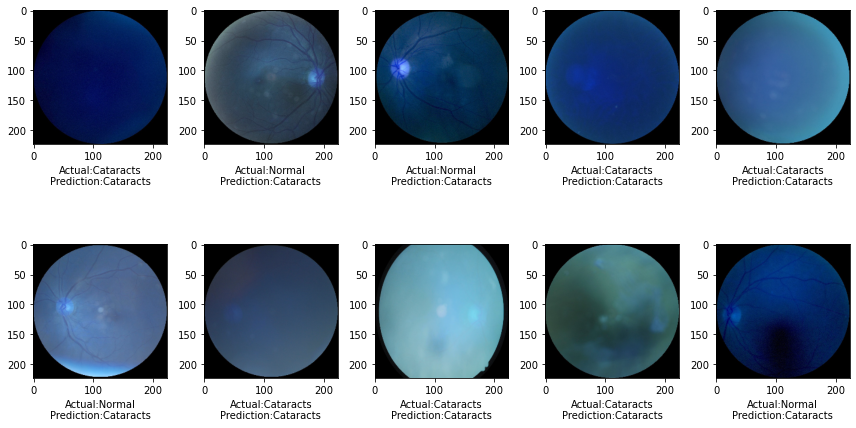

In [272]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Cataracts"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataracts"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label}\nPrediction:{pred_label}")
plt.tight_layout()

#### Model 1: Cataracts

In [11]:
# inspiration from https://www.kaggle.com/taha07/cataract-prediction-using-vgg19
file_names = []
labels = []

In [12]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["C"], df["Left-Fundus"]):
    
    if(("cataract" in text) and (label == 1)):
        file_names.append(file_name)
        labels.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names.append(file_name)
        labels.append(0)

In [13]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["C"], df["Right-Fundus"]):
    
    if(("cataract" in text) and (label == 1)):
        file_names.append(file_name)
        labels.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names.append(file_name)
        labels.append(0)

In [14]:
ROW = 224
COL = 224
image_data = []
for idx, image_name in enumerate(file_names):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data.append(img)
    except:
        del labels[idx]
    
image_data = np.array(image_data)

In [15]:
temp = []
for idx, label in enumerate(labels):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data[idx])
    y_data.append(labels[idx])

temp = []
for idx, label in enumerate(labels):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data[idx])
    y_data.append(labels[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 1)

In [17]:
vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(ROW, COL, 3))
for layer in vgg.layers:
    layer.trainable = False

In [34]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2,activation = "softmax"))

model.summary()

In [232]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 15,
                    batch_size = 64)

Epoch 1/15
15/15 [==============================] - 263s 18s/step - loss: 7.1699 - accuracy: 0.7548 - precision: 0.7548 - recall: 0.7548 - val_loss: 0.8571 - val_accuracy: 0.9195 - val_precision: 0.9195 - val_recall: 0.9195
Epoch 2/15
15/15 [==============================] - 258s 17s/step - loss: 0.7398 - accuracy: 0.7197 - precision: 0.7197 - recall: 0.7197 - val_loss: 0.3673 - val_accuracy: 0.6186 - val_precision: 0.6186 - val_recall: 0.6186
Epoch 3/15
15/15 [==============================] - 263s 18s/step - loss: 0.3039 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - val_loss: 0.2375 - val_accuracy: 0.9322 - val_precision: 0.9322 - val_recall: 0.9322
Epoch 4/15
15/15 [==============================] - 265s 18s/step - loss: 0.2494 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - val_loss: 0.2587 - val_accuracy: 0.9322 - val_precision: 0.9322 - val_recall: 0.9322
Epoch 5/15
15/15 [==============================] - 260s 17s/step - loss: 0.2056 - accuracy: 0.9236 - pr

In [20]:
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


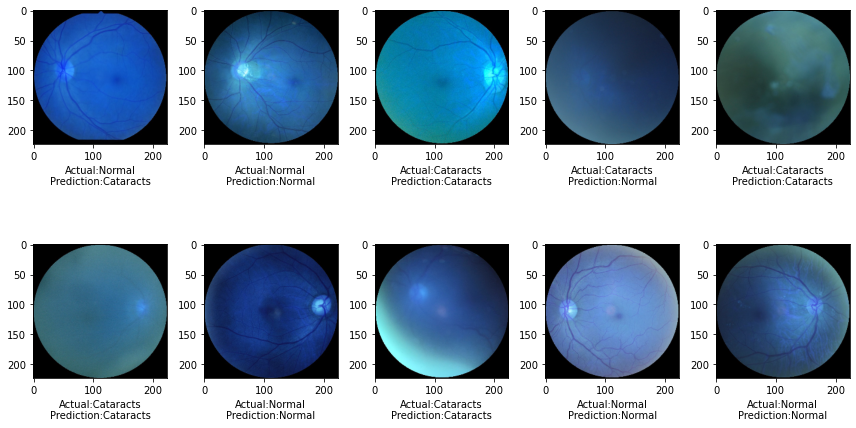

In [26]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Cataracts"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataracts"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label}\nPrediction:{pred_label}")
plt.tight_layout()

#### Model 2: Age-related Macular Degeneration

In [88]:
file_names_amd = []
labels_amd = []

In [89]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["A"], df["Left-Fundus"]):
    
    if(("age-related" in text) and (label == 1)):
        file_names_amd.append(file_name)
        labels_amd.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_amd.append(file_name)
        labels_amd.append(0)

In [90]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["A"], df["Right-Fundus"]):
    
    if(("age-related" in text) and (label == 1)):
        file_names_amd.append(file_name)
        labels_amd.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_amd.append(file_name)
        labels_amd.append(0)

In [91]:
ROW = 224
COL = 224
image_data_amd = []
for idx, image_name in enumerate(file_names_amd):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data_amd.append(img)
    except:
        del labels_amd[idx]
    
image_data_amd = np.array(image_data_amd)

In [92]:
temp = []
for idx, label in enumerate(labels_amd):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_amd if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_amd[idx])
    y_data.append(labels_amd[idx])

temp = []
for idx, label in enumerate(labels_amd):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_amd[idx])
    y_data.append(labels_amd[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 1)

In [94]:
vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(ROW, COL, 3))
for layer in vgg.layers:
    layer.trainable = False

In [95]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2,activation = "softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 21,630,210
Trainable params: 1,605,826
Non-trainable params: 20,024,384
_________________________________________________________________


In [295]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 15,
                    batch_size = 21)

Epoch 1/15
42/42 [==============================] - 225s 5s/step - loss: 0.6932 - accuracy: 0.5017 - precision: 0.5017 - recall: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 0.4931
Epoch 2/15
42/42 [==============================] - 222s 5s/step - loss: 0.6932 - accuracy: 0.5017 - precision: 0.5017 - recall: 0.5017 - val_loss: 0.6933 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 0.4931
Epoch 3/15
42/42 [==============================] - 221s 5s/step - loss: 0.6932 - accuracy: 0.5017 - precision: 0.5017 - recall: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 0.4931
Epoch 4/15
42/42 [==============================] - 221s 5s/step - loss: 0.6932 - accuracy: 0.4786 - precision: 0.4786 - recall: 0.4786 - val_loss: 0.6931 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 0.4931
Epoch 5/15
42/42 [==============================] - 222s 5s/step - loss: 0.6932 - accuracy: 0.5017 - precisi

In [96]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

In [97]:
y_pred = model.predict_classes(X_test)

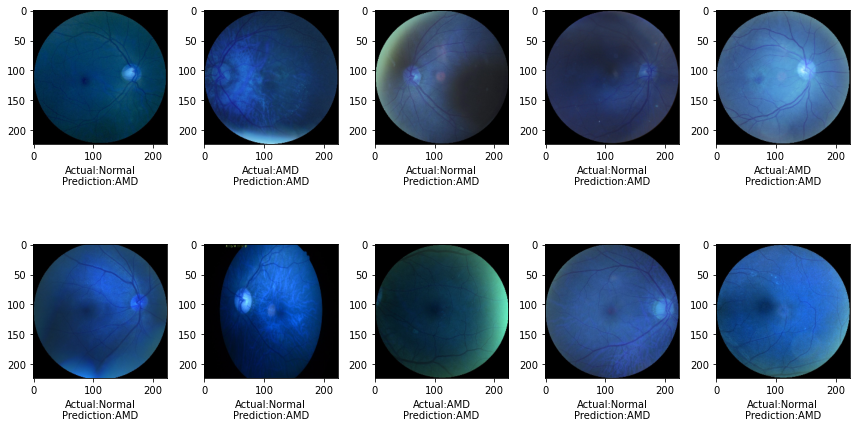

In [99]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "AMD"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "AMD"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label}\nPrediction:{ored_label}")
plt.tight_layout()

#### Model 3: Hypertension

In [125]:
# inspiration from https://www.kaggle.com/mateuszbagiski/odir5k-predicting-from-extracted-features
# inspiration from 
file_names_hyper = []
labels_hyper = []

In [126]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["H"], df["Left-Fundus"]):
    
    if(("hypertensive" in text) and (label == 1)):
        file_names_hyper.append(file_name)
        labels_hyper.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_hyper.append(file_name)
        labels_hyper.append(0)

In [127]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["H"], df["Right-Fundus"]):
    
    if(("hypertensive" in text) and (label == 1)):
        file_names_hyper.append(file_name)
        labels_hyper.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_hyper.append(file_name)
        labels_hyper.append(0)

In [128]:
ROW = 224
COL = 224
image_data_hyper = []
for idx, image_name in enumerate(file_names_hyper):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data_hyper.append(img)
    except:
        del labels_hyper[idx]
    
image_data_hyper = np.array(image_data_hyper)

In [129]:
temp = []
for idx, label in enumerate(labels_hyper):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_hyper if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_hyper[idx])
    y_data.append(labels_hyper[idx])

temp = []
for idx, label in enumerate(labels_hyper):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_hyper[idx])
    y_data.append(labels_hyper[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 1)

In [131]:
vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(ROW, COL, 3))
for layer in vgg.layers:
    layer.trainable = False

In [132]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2,activation = "softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 21,630,210
Trainable params: 1,605,826
Non-trainable params: 20,024,384
_________________________________________________________________


In [81]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 15,
                    batch_size = 21)

Epoch 1/15
29/29 [==============================] - 160s 6s/step - loss: 9.0758 - accuracy: 0.5364 - precision: 0.5364 - recall: 0.5364 - val_loss: 2.2561 - val_accuracy: 0.6579 - val_precision: 0.6579 - val_recall: 0.6579
Epoch 2/15
29/29 [==============================] - 159s 5s/step - loss: 0.8362 - accuracy: 0.8013 - precision: 0.8013 - recall: 0.8013 - val_loss: 1.4854 - val_accuracy: 0.6908 - val_precision: 0.6908 - val_recall: 0.6908
Epoch 3/15
29/29 [==============================] - 153s 5s/step - loss: 0.7013 - accuracy: 0.8129 - precision: 0.8129 - recall: 0.8129 - val_loss: 2.1603 - val_accuracy: 0.7105 - val_precision: 0.7105 - val_recall: 0.7105
Epoch 4/15
29/29 [==============================] - 154s 5s/step - loss: 0.5247 - accuracy: 0.8742 - precision: 0.8742 - recall: 0.8742 - val_loss: 2.0417 - val_accuracy: 0.6645 - val_precision: 0.6645 - val_recall: 0.6645
Epoch 5/15
29/29 [==============================] - 153s 5s/step - loss: 0.2996 - accuracy: 0.9156 - precisi

In [134]:
y_pred = model.predict_classes(X_test)

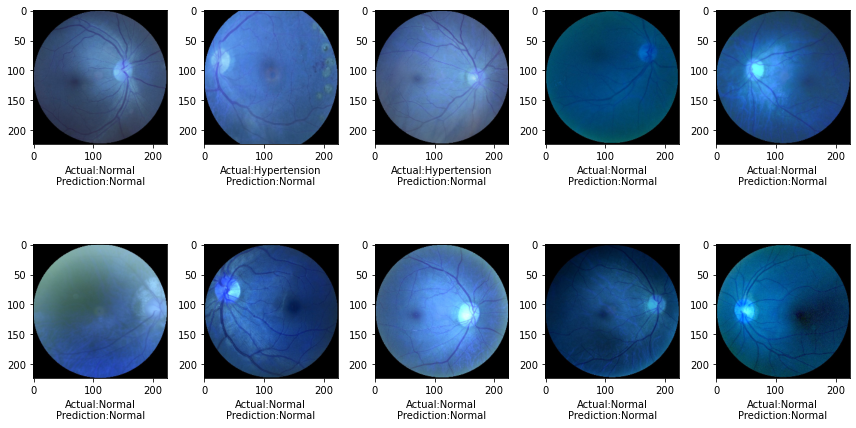

In [137]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Hypertension"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Hypertension"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label}\nPrediction:{pred_label}")
plt.tight_layout()

#### Model 4: Myopia

In [138]:
file_names_myopia = []
labels_myopia = []

In [139]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["M"], df["Left-Fundus"]):
    
    if(("myopia" in text) and (label == 1)):
        file_names_myopia.append(file_name)
        labels_myopia.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_myopia.append(file_name)
        labels_myopia.append(0)

In [140]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["M"], df["Right-Fundus"]):
    
    if(("myopia" in text) and (label == 1)):
        file_names_myopia.append(file_name)
        labels_myopia.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_myopia.append(file_name)
        labels_myopia.append(0)

In [141]:
ROW = 224
COL = 224
image_data_myopia = []
for idx, image_name in enumerate(file_names_myopia):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data_myopia.append(img)
    except:
        del labels_myopia[idx]
    
image_data_myopia = np.array(image_data_myopia)

In [142]:
temp = []
for idx, label in enumerate(labels_myopia):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_myopia if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_myopia[idx])
    y_data.append(labels_myopia[idx])

temp = []
for idx, label in enumerate(labels_myopia):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_myopia[idx])
    y_data.append(labels_myopia[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 1)

In [144]:
vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(ROW, COL, 3))
for layer in vgg.layers:
    layer.trainable = False

In [145]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2,activation = "softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 21,630,210
Trainable params: 1,605,826
Non-trainable params: 20,024,384
_________________________________________________________________


In [66]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 15,
                    batch_size = 21)

Epoch 1/15
37/37 [==============================] - 219s 6s/step - loss: 8.9601 - accuracy: 0.7746 - precision: 0.7746 - recall: 0.7746 - val_loss: 0.3781 - val_accuracy: 0.9058 - val_precision: 0.9058 - val_recall: 0.9058
Epoch 2/15
37/37 [==============================] - 204s 6s/step - loss: 0.2940 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - val_loss: 0.3204 - val_accuracy: 0.9162 - val_precision: 0.9162 - val_recall: 0.9162
Epoch 3/15
37/37 [==============================] - 198s 5s/step - loss: 0.2337 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - val_loss: 0.2611 - val_accuracy: 0.9162 - val_precision: 0.9162 - val_recall: 0.9162
Epoch 4/15
37/37 [==============================] - 202s 5s/step - loss: 0.1599 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - val_loss: 0.2646 - val_accuracy: 0.9058 - val_precision: 0.9058 - val_recall: 0.9058
Epoch 5/15
37/37 [==============================] - 199s 5s/step - loss: 0.0953 - accuracy: 0.9541 - precisi

In [147]:
y_pred = model.predict_classes(X_test)

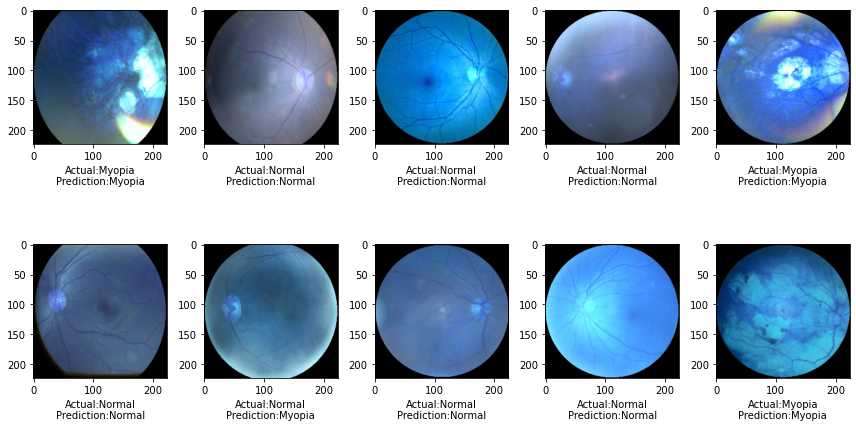

In [184]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Myopia"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Myopia"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label} \n Prediction:{pred_label}")
plt.tight_layout()

#### Model 5: Age-related Macular Degeneration Part 2

In [186]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('ocular_disease_fundus/preprocessed_images')
TRAIN_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/AMD vs Normal Training'
VAL_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/AMD vs Normal Testing'

In [187]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [188]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                            class_mode='categorical')

Found 1603 images belonging to 2 classes.
Found 952 images belonging to 2 classes.


In [189]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [190]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [191]:
num_classes = 2

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 2050      
Total params: 26,737,538
Trainable params: 12,081,154
Non-trainable params: 14,656,384
_________________________________

In [192]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [193]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [119]:
model.fit(train_generator,
          steps_per_epoch=np.ceil(float(1603) / float(BATCH_SIZE)),
          epochs = 20,callbacks=[early_stop,reduce_lr],
          validation_steps=np.ceil(float(952) / float(BATCH_SIZE)),
          validation_data = validation_generator)

Epoch 1/20
65/65 [==============================] - 266s 4s/step - loss: 0.9524 - accuracy: 0.8553 - f1_score: 0.5575 - val_loss: 1.6112 - val_accuracy: 0.8571 - val_f1_score: 0.4687
Epoch 2/20
65/65 [==============================] - 263s 4s/step - loss: 0.6590 - accuracy: 0.8752 - f1_score: 0.6036 - val_loss: 1.3278 - val_accuracy: 0.8645 - val_f1_score: 0.5185
Epoch 3/20
65/65 [==============================] - 258s 4s/step - loss: 0.4445 - accuracy: 0.9021 - f1_score: 0.6836 - val_loss: 0.9638 - val_accuracy: 0.8708 - val_f1_score: 0.5731
Epoch 4/20
65/65 [==============================] - 258s 4s/step - loss: 0.3812 - accuracy: 0.9170 - f1_score: 0.7283 - val_loss: 1.0943 - val_accuracy: 0.8729 - val_f1_score: 0.5941
Epoch 5/20
65/65 [==============================] - 257s 4s/step - loss: 0.3110 - accuracy: 0.9195 - f1_score: 0.7417 - val_loss: 0.8409 - val_accuracy: 0.8803 - val_f1_score: 0.6468
Epoch 6/20
65/65 [==============================] - 258s 4s/step - loss: 0.2529 - acc

In [194]:
y_pred = model.predict_classes(X_test)

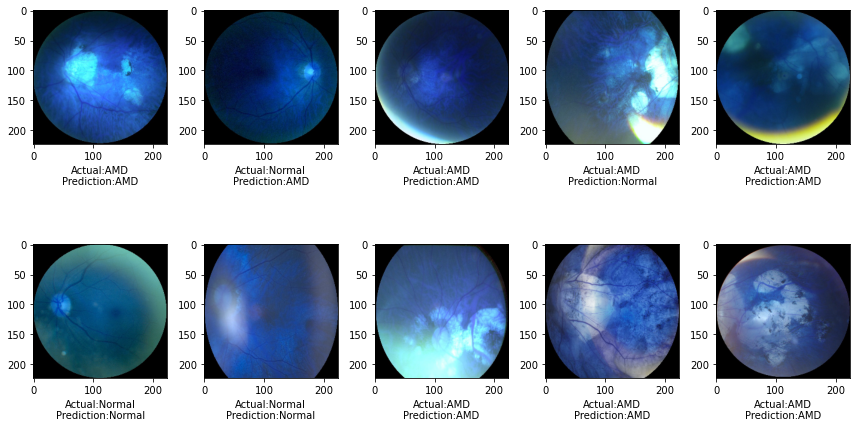

In [196]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "AMD"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "AMD"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{label} \n Prediction:{pred_label}")
plt.tight_layout()

#### Model 6: Hypertension Part 2

In [197]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('ocular_disease_fundus/preprocessed_images')
TRAIN_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Hyper vs Normal Training'
VAL_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Hyper vs Normal Testing'

In [198]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [199]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                            class_mode='categorical')

Found 1590 images belonging to 2 classes.
Found 892 images belonging to 2 classes.


In [200]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [201]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [202]:
num_classes = 2

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 2050      
Total params: 26,737,538
Trainable params: 12,081,154
Non-trainable params: 14,656,384
_________________________________

In [203]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [204]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [133]:
model.fit(train_generator,
          steps_per_epoch=np.ceil(float(1590) / float(BATCH_SIZE)),
          epochs = 15,callbacks=[early_stop,reduce_lr],
          validation_steps=np.ceil(float(892) / float(BATCH_SIZE)),
          validation_data = validation_generator)

Epoch 1/15
64/64 [==============================] - 264s 4s/step - loss: 1.5202 - accuracy: 0.8560 - f1_score: 0.5118 - val_loss: 0.7226 - val_accuracy: 0.9137 - val_f1_score: 0.4774
Epoch 2/15
64/64 [==============================] - 259s 4s/step - loss: 1.0180 - accuracy: 0.8579 - f1_score: 0.5233 - val_loss: 0.7828 - val_accuracy: 0.9137 - val_f1_score: 0.4774
Epoch 3/15
64/64 [==============================] - 260s 4s/step - loss: 0.7392 - accuracy: 0.8704 - f1_score: 0.5528 - val_loss: 0.5828 - val_accuracy: 0.9170 - val_f1_score: 0.5158
Epoch 4/15
64/64 [==============================] - 257s 4s/step - loss: 0.5159 - accuracy: 0.8868 - f1_score: 0.5881 - val_loss: 0.4465 - val_accuracy: 0.9283 - val_f1_score: 0.6256
Epoch 5/15
64/64 [==============================] - 274s 4s/step - loss: 0.3604 - accuracy: 0.9031 - f1_score: 0.6476 - val_loss: 0.3547 - val_accuracy: 0.9417 - val_f1_score: 0.7437
Epoch 6/15
64/64 [==============================] - 298s 5s/step - loss: 0.3662 - acc

In [205]:
y_pred = model.predict_classes(X_test)

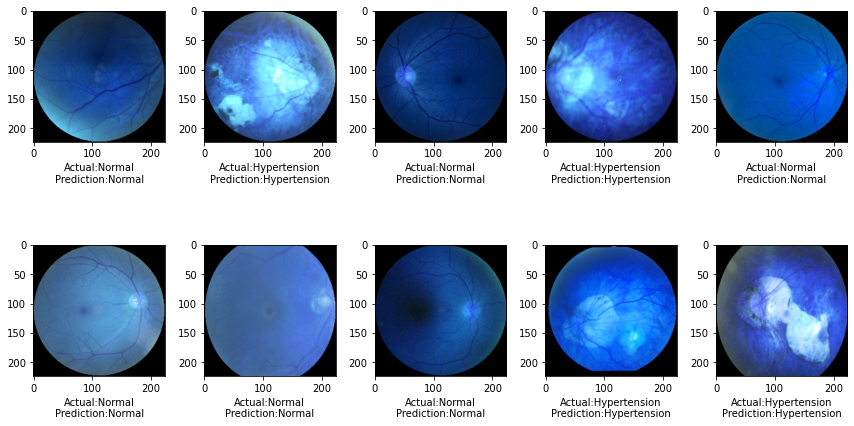

In [217]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Hypertension"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Hypertension"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label}\nPrediction:{pred_label}")
plt.tight_layout()

#### Model 7: Glaucoma

In [218]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('ocular_disease_fundus/preprocessed_images')
TRAIN_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Glaucoma vs Normal Training'
VAL_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Glaucoma vs Normal Testing'

In [219]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [220]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                            class_mode='categorical')

Found 1757 images belonging to 2 classes.
Found 1012 images belonging to 2 classes.


In [221]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [222]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [223]:
num_classes = 2

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_5 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 2050      
Total params: 26,737,538
Trainable params: 12,081,154
Non-trainable params: 14,656,384
_________________________________

In [224]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [225]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [226]:
model.fit(train_generator,
          steps_per_epoch=np.ceil(float(1757) / float(BATCH_SIZE)),
          epochs = 15,callbacks=[early_stop,reduce_lr],
          validation_steps=np.ceil(float(1012) / float(BATCH_SIZE)),
          validation_data = validation_generator)

Epoch 1/15
71/71 [==============================] - 376s 5s/step - loss: 2.0925 - accuracy: 0.7513 - f1_score: 0.5555 - val_loss: 2.5420 - val_accuracy: 0.8053 - val_f1_score: 0.4511
Epoch 2/15
71/71 [==============================] - 354s 5s/step - loss: 1.1184 - accuracy: 0.7934 - f1_score: 0.6161 - val_loss: 1.6775 - val_accuracy: 0.7964 - val_f1_score: 0.5131
Epoch 3/15
71/71 [==============================] - 366s 5s/step - loss: 0.7965 - accuracy: 0.8008 - f1_score: 0.6564 - val_loss: 1.1156 - val_accuracy: 0.8004 - val_f1_score: 0.5260
Epoch 4/15
71/71 [==============================] - 354s 5s/step - loss: 0.6572 - accuracy: 0.8127 - f1_score: 0.6698 - val_loss: 1.4100 - val_accuracy: 0.8142 - val_f1_score: 0.5128
Epoch 5/15
71/71 [==============================] - 359s 5s/step - loss: 0.5785 - accuracy: 0.8270 - f1_score: 0.6790 - val_loss: 0.9385 - val_accuracy: 0.8291 - val_f1_score: 0.6195
Epoch 6/15
71/71 [==============================] - 330s 5s/step - loss: 0.4560 - acc

In [227]:
y_pred = model.predict_classes(X_test)

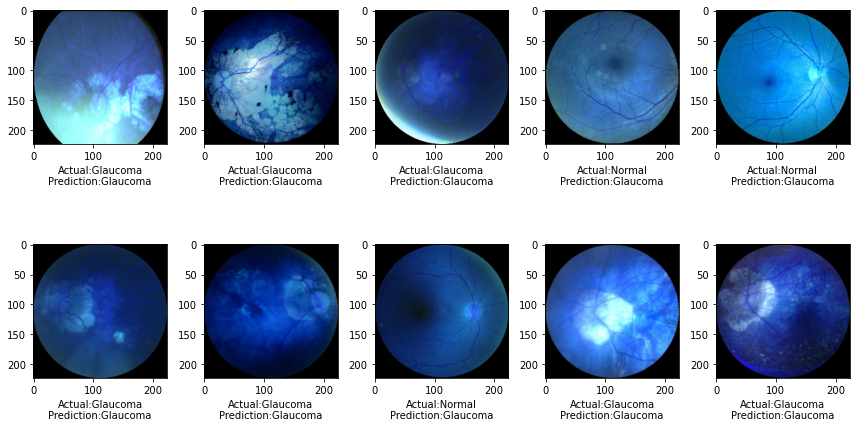

In [234]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Glaucoma"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Glaucoma"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label}\nPrediction:{pred_label}")
plt.tight_layout()

#### Model 8: Glaucoma Part 2

In [288]:
file_names_g = []
labels_g = []

In [289]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["G"], df["Left-Fundus"]):
    
    if(("glaucoma" in text) and (label == 1)):
        file_names_g.append(file_name)
        labels_g.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_g.append(file_name)
        labels_g.append(0)

In [290]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["G"], df["Right-Fundus"]):
    
    if(("glaucoma" in text) and (label == 1)):
        file_names_g.append(file_name)
        labels_g.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_g.append(file_name)
        labels_g.append(0)

In [291]:
ROW = 224
COL = 224
image_data_g = []
for idx, image_name in enumerate(file_names_g):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data_g.append(img)
    except:
        del labels_g[idx]
    
image_data_g = np.array(image_data_g)

In [292]:
temp = []
for idx, label in enumerate(labels_g):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_g if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_g[idx])
    y_data.append(labels_g[idx])

temp = []
for idx, label in enumerate(labels_g):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_g[idx])
    y_data.append(labels_g[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [293]:
temp = []
for idx, label in enumerate(labels_g):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_g if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_g[idx])
    y_data.append(labels_g[idx])

temp = []
for idx, label in enumerate(labels_g):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_g[idx])
    y_data.append(labels_g[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [294]:
np.random.seed(1000)
AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Flatten())

AlexNet.add(Dense(64, input_shape=(224,224,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(64))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_8 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
activation_8 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 256)     

In [295]:
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(X_train)
test_generator.fit(X_test)
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.01,   patience=3,  min_lr=1e-5) 

In [296]:
AlexNet.compile(optimizer= 'adam', loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])
AlexNet.fit(train_generator.flow(X_train, y_train, batch_size=64), 
                      epochs = 15, 
                      steps_per_epoch = X_train.shape[0]//64, 
                      validation_data = test_generator.flow(X_test, y_test, batch_size=64), 
                      validation_steps = X_train.shape[0]//64,
                      callbacks = [lrr], 
                      verbose=1)

Epoch 1/15
15/15 [==============================] - 59s 4s/step - loss: 0.7920 - accuracy: 0.5440 - precision: 0.5440 - recall: 0.5440 - val_loss: 271.4199 - val_accuracy: 0.5082 - val_precision: 0.5082 - val_recall: 0.5082
Epoch 2/15
15/15 [==============================] - 54s 4s/step - loss: 0.7200 - accuracy: 0.6033 - precision: 0.6033 - recall: 0.6033
Epoch 3/15
15/15 [==============================] - 53s 4s/step - loss: 0.7371 - accuracy: 0.5857 - precision: 0.5857 - recall: 0.5857
Epoch 4/15
15/15 [==============================] - 53s 4s/step - loss: 0.6781 - accuracy: 0.6044 - precision: 0.6044 - recall: 0.6044
Epoch 5/15
15/15 [==============================] - 54s 4s/step - loss: 0.7051 - accuracy: 0.5758 - precision: 0.5758 - recall: 0.5758
Epoch 6/15
15/15 [==============================] - 54s 4s/step - loss: 0.6896 - accuracy: 0.5956 - precision: 0.5956 - recall: 0.5956
Epoch 7/15
15/15 [==============================] - 54s 4s/step - loss: 0.6736 - accuracy: 0.6132 - p

In [297]:
y_pred = AlexNet.predict_classes(X_test)

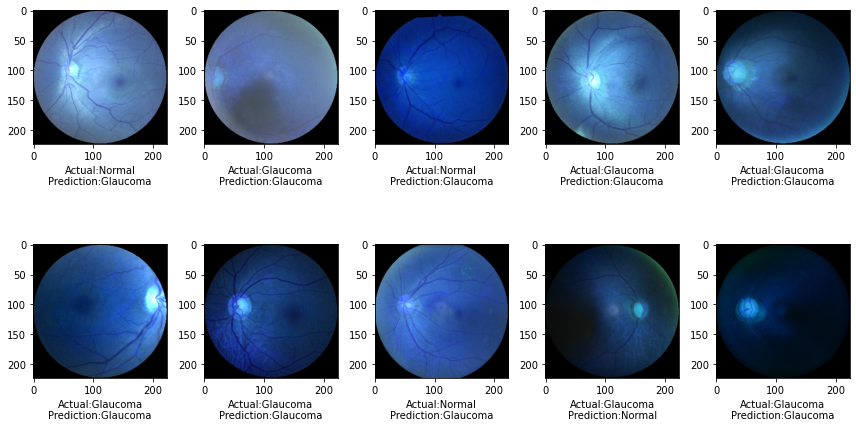

In [298]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Glaucoma"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Glaucoma"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{label} \n Prediction:{pred_label}")
plt.tight_layout()

#### Model 9:Myopia Part 2

In [299]:
file_names_m = []
labels_m = []

In [300]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["M"], df["Left-Fundus"]):
    
    if(("myopia" in text) and (label == 1)):
        file_names_m.append(file_name)
        labels_m.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_m.append(file_name)
        labels_m.append(0)

In [301]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["M"], df["Right-Fundus"]):
    
    if(("myopia" in text) and (label == 1)):
        file_names_m.append(file_name)
        labels_m.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_m.append(file_name)
        labels_m.append(0)

In [302]:
ROW = 224
COL = 224
image_data_m = []
for idx, image_name in enumerate(file_names_m):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data_m.append(img)
    except:
        del labels_m[idx]
    
image_data_m = np.array(image_data_m)

In [303]:
temp = []
for idx, label in enumerate(labels_m):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_m if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_m[idx])
    y_data.append(labels_m[idx])

temp = []
for idx, label in enumerate(labels_m):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_m[idx])
    y_data.append(labels_m[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [304]:
np.random.seed(1000)
AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Flatten())

AlexNet.add(Dense(64, input_shape=(224,224,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(64))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_16 (Batc (None, 56, 56, 96)        384       
_________________________________________________________________
activation_16 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 256)     

In [305]:
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(X_train)
test_generator.fit(X_test)
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.01,   patience=3,  min_lr=1e-5) 

In [306]:
AlexNet.compile(optimizer= 'adam', loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])
AlexNet.fit(train_generator.flow(X_train, y_train, batch_size=64), 
                      epochs = 15, 
                      steps_per_epoch = X_train.shape[0]//64, 
                      validation_data = test_generator.flow(X_test, y_test, batch_size=64), 
                      validation_steps = X_train.shape[0]//64,
                      callbacks = [lrr], 
                      verbose=1)

Epoch 1/15
15/15 [==============================] - 64s 4s/step - loss: 0.7832 - accuracy: 0.5264 - precision: 0.5264 - recall: 0.5264 - val_loss: 184.6864 - val_accuracy: 0.5041 - val_precision: 0.5041 - val_recall: 0.5041
Epoch 2/15
15/15 [==============================] - 54s 4s/step - loss: 0.7236 - accuracy: 0.5802 - precision: 0.5802 - recall: 0.5802
Epoch 3/15
15/15 [==============================] - 57s 4s/step - loss: 0.6787 - accuracy: 0.6132 - precision: 0.6132 - recall: 0.6132
Epoch 4/15
15/15 [==============================] - 54s 4s/step - loss: 0.6987 - accuracy: 0.5901 - precision: 0.5901 - recall: 0.5901
Epoch 5/15
15/15 [==============================] - 54s 4s/step - loss: 0.6669 - accuracy: 0.6099 - precision: 0.6099 - recall: 0.6099
Epoch 6/15
15/15 [==============================] - 54s 4s/step - loss: 0.6616 - accuracy: 0.6209 - precision: 0.6209 - recall: 0.6209
Epoch 7/15
15/15 [==============================] - 54s 4s/step - loss: 0.6489 - accuracy: 0.6352 - p

In [307]:
y_pred = AlexNet.predict_classes(X_test)

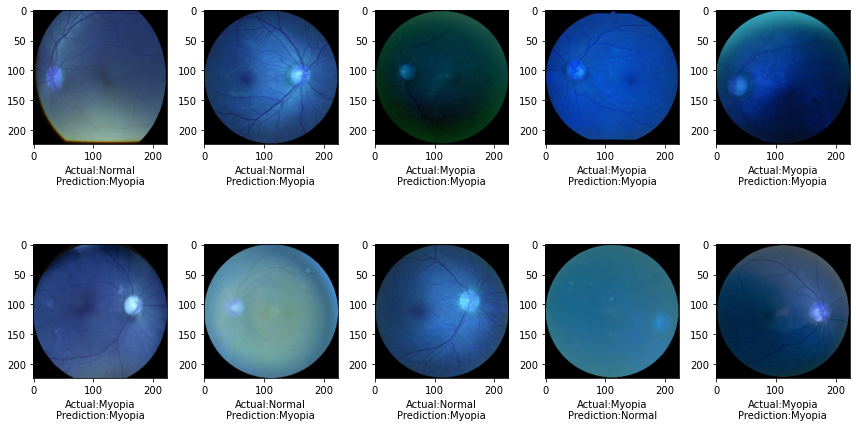

In [308]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Myopia"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Myopia"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label}\nPrediction:{pred_label}")
plt.tight_layout()

#### Model 10:Diabetes

In [38]:
file_names_d = []
labels_d = []

In [39]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["D"], df["Left-Fundus"]):
    
    if(("proliferative retinopathy" in text) and (label == 1)):
        file_names_d.append(file_name)
        labels_d.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_d.append(file_name)
        labels_d.append(0)

In [40]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["D"], df["Right-Fundus"]):
    
    if(("proliferative retinopathy" in text) and (label == 1)):
        file_names_d.append(file_name)
        labels_d.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_d.append(file_name)
        labels_d.append(0)

In [43]:
ROW = 224
COL = 224
image_data_d = []
for idx, image_name in enumerate(file_names_d):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data_d.append(img)
    except:
        del labels_d[idx]
    
image_data_d = np.array(image_data_d)

In [44]:
temp = []
for idx, label in enumerate(labels_d):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_d if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_d[idx])
    y_data.append(labels_d[idx])

temp = []
for idx, label in enumerate(labels_d):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_d[idx])
    y_data.append(labels_d[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [45]:
np.random.seed(1000)
AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Flatten())

AlexNet.add(Dense(64, input_shape=(224,224,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(64))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_8 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
activation_8 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 256)      

In [46]:
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(X_train)
test_generator.fit(X_test)
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.01,   patience=3,  min_lr=1e-5) 

In [29]:
AlexNet.compile(optimizer= 'adam', loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])
AlexNet.fit(train_generator.flow(X_train, y_train, batch_size=64), 
                      epochs = 15, 
                      steps_per_epoch = X_train.shape[0]//64, 
                      validation_data = test_generator.flow(X_test, y_test, batch_size=64), 
                      validation_steps = X_train.shape[0]//64,
                      callbacks = [lrr], 
                      verbose=1)

Epoch 1/15
80/80 [==============================] - 363s 5s/step - loss: 0.7407 - accuracy: 0.5503 - precision: 0.5503 - recall: 0.5503 - val_loss: 3.2974 - val_accuracy: 0.4716 - val_precision: 0.4716 - val_recall: 0.4716
Epoch 2/15
80/80 [==============================] - 325s 4s/step - loss: 0.6866 - accuracy: 0.5764 - precision: 0.5764 - recall: 0.5764
Epoch 3/15
80/80 [==============================] - 325s 4s/step - loss: 0.6810 - accuracy: 0.5781 - precision: 0.5781 - recall: 0.5781
Epoch 4/15
80/80 [==============================] - 340s 4s/step - loss: 0.6731 - accuracy: 0.5839 - precision: 0.5839 - recall: 0.5839
Epoch 5/15
80/80 [==============================] - 330s 4s/step - loss: 0.6725 - accuracy: 0.5874 - precision: 0.5874 - recall: 0.5874
Epoch 6/15
80/80 [==============================] - 369s 5s/step - loss: 0.6727 - accuracy: 0.5863 - precision: 0.5863 - recall: 0.5863
Epoch 7/15
80/80 [==============================] - 366s 5s/step - loss: 0.6679 - accuracy: 0.590

In [71]:
y_pred = AlexNet.predict_classes(X_test)

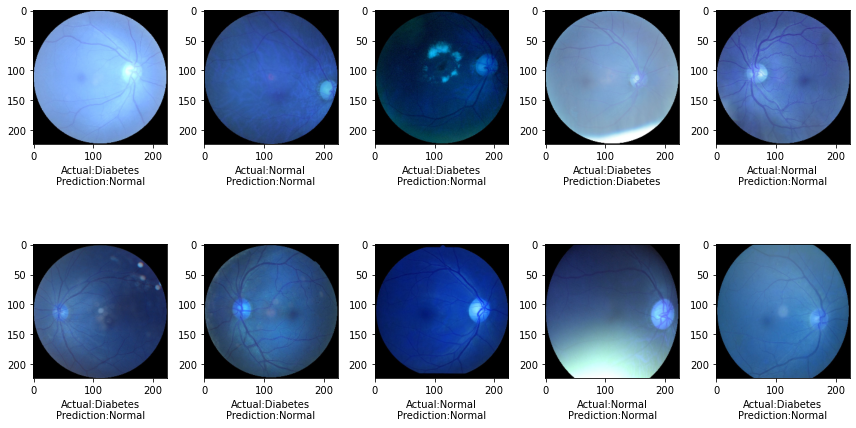

In [74]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    if category == 0:
        label = "Normal"
    else:
        label = "Diabetes"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Diabetes"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label}\nPrediction:{pred_label}")
plt.tight_layout()